In [1]:
# import essential libraries

import numpy as np 
from tensorflow import keras 
from sklearn.metrics import confusion_matrix 
from keras.preprocessing.image import ImageDataGenerator
import itertools
import matplotlib.pyplot as plt 
import warnings 
warnings.simplefilter('ignore')
import cv2

In [2]:
# load the image_batches

train_path =r"C:\Users\hp\Desktop\artificial intelligence python\major project\face mask detection\train_"
test_path = r"C:\Users\hp\Desktop\artificial intelligence python\major project\face mask detection\test"
validation_path =r"C:\Users\hp\Desktop\artificial intelligence python\major project\face mask detection\Validation"

train_batches= ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input)\
.flow_from_directory(train_path, target_size=(224,224), batch_size=16)

test_batches= ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input)\
.flow_from_directory(test_path, target_size=(224,224), batch_size=16, shuffle=False)

validation_batches= ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input)\
.flow_from_directory(validation_path, target_size=(224,224), batch_size=16)

Found 4004 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [3]:

# we will use the mobilenet

base_model = keras.applications.mobilenet.MobileNet()
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [4]:
model = keras.Sequential()

for layer in base_model.layers[:-1]:
    model.add(layer)

In [5]:
# Now freeze all layers of this model except last 5

for layer in model.layers[:-6]:
    layer.trainable = False

In [6]:
# add new dense layer for the as output layer

model.add(keras.layers.Dense(units=2, activation='softmax'))

In [7]:
# specify the loss, optimizer and metrics parameters

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

# now fit the model
model.fit(train_batches,validation_data=validation_batches, epochs=5, verbose=1)

Epoch 1/5
251/251 [==============================] - 139s 531ms/step - loss: 0.6589 - accuracy: 0.9384 - val_loss: 0.0815 - val_accuracy: 0.9850
Epoch 2/5
251/251 [==============================] - 111s 440ms/step - loss: 0.0565 - accuracy: 0.9904 - val_loss: 0.2625 - val_accuracy: 0.9775
Epoch 3/5
251/251 [==============================] - 111s 443ms/step - loss: 0.0515 - accuracy: 0.9940 - val_loss: 1.6305e-04 - val_accuracy: 1.0000
Epoch 4/5
251/251 [==============================] - 110s 437ms/step - loss: 0.0151 - accuracy: 0.9973 - val_loss: 0.1713 - val_accuracy: 0.9825
Epoch 5/5
251/251 [==============================] - 110s 439ms/step - loss: 0.0264 - accuracy: 0.9948 - val_loss: 0.0379 - val_accuracy: 0.9950


In [8]:
# model evaluation
loss, accuracy = model.evaluate(test_batches, verbose=1)
print("loss :-", loss)
print("accuracy :-", accuracy*100)

25/25 [==============================] - 12s 494ms/step - loss: 0.0150 - accuracy: 0.9950
loss :- 0.014959048479795456
accuracy :- 99.50000047683716


In [9]:
# let's predict the test data

prediction = model.predict(x=test_batches, verbose=0)

In [10]:
# create the confusion matrix 
test_labels = test_batches.classes
cm = confusion_matrix(y_true=test_labels, y_pred=np.argmax(prediction, axis=-1))

In [11]:
# function to print the confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[199   1]
 [  1 199]]


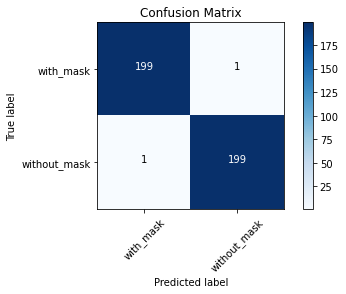

In [12]:
# plot the confusion matrix

cm_plot_labels = ['with_mask','without_mask']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [13]:
# save the model 

model.save("mask_detector.h5")

In [14]:
import tensorflow as tf
model = tf.keras.models.load_model('mask_detector.h5')

In [15]:
import cv2
import numpy as np
from keras.models import load_model
model = tf.keras.models.load_model('mask_detector.h5')

results={0:'with_mask',1:'without_mask'}
GR_dict={0:(0,255,0),1:(0,0,255)}

rect_size = 4
cap = cv2.VideoCapture(0) 


haarcascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

while True:
    (rval, im) = cap.read()
    im=cv2.flip(im,1,1) 

    
    rerect_size = cv2.resize(im, (im.shape[1] // rect_size, im.shape[0] // rect_size))
    faces = haarcascade.detectMultiScale(rerect_size)
    for f in faces:
        (x, y, w, h) = [v * rect_size for v in f] 
        
        face_img = im[y:y+h, x:x+w]
        rerect_sized=cv2.resize(face_img,(150,150))
        normalized=rerect_sized/255.0
        reshaped=np.reshape(normalized,(1,150,150,3))
        reshaped = np.vstack([reshaped])
        result=model.predict(reshaped)

        
        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(im,(x,y),(x+w,y+h),GR_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),GR_dict[label],-1)
        cv2.putText(im, results[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)

    cv2.imshow('LIVE',   im)
    key = cv2.waitKey(10)
    
    if key == 27: 
        break

cap.release()

cv2.destroyAllWindows()

KeyboardInterrupt: 